In [1]:
import math
import os
import cv2
import numpy as np
import pandas as pd
import time
import mediapipe as mp
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [3]:
mp_pose = mp.solutions.pose

pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)

# tracker = cv2.TrackerCSRT_create()

mp_drawing = mp.solutions.drawing_utils

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


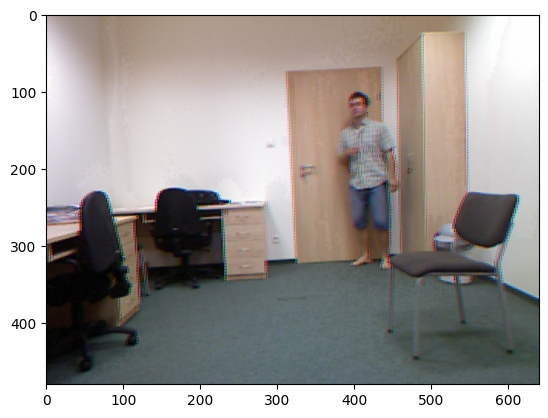

In [4]:
img = 'ufall_dataset/fall-05-cam0-rgb/fall-05-cam0-rgb-001'
sample_image = cv2.imread(os.path.join(img+'.png'))

# sample_image = cv2.imread('image.jpg')

plt.imshow(sample_image[:,:,::-1])

# plt.show()

In [5]:
def Posedetection(image,pose,display=False):
    img_copy = image.copy()
    
    img_RGB = cv2.cvtColor(img_copy,cv2.COLOR_BGR2RGB)
    
    results = pose.process(img_RGB)
    
    h,w,d = image.shape
    
    l = []
    flattened_keypoints = []
    ls = []
    
    if results.pose_landmarks:
#         important
        mp_drawing.draw_landmarks(image=img_copy, landmark_list = results.pose_landmarks, connections = mp_pose.POSE_CONNECTIONS)
        
        
        for landmark in results.pose_landmarks.landmark:
            
            l.append([int(landmark.x * w),int(landmark.y * h),int(landmark.z * w)])
            
        l = l[7:]
    
#   ----------------------
        
#         for landmark in results.pose_landmarks.landmark:
#             ls.append((int(landmark.x),int(landmark.y),int(landmark.z)))
        
        for kp in l:
           flattened_keypoints.extend(kp)
    
    
#   ----------------------  
    if display:
        
        plt.subplot(121).imshow(image[:,:,::-1]);
        plt.subplot(122).imshow(img_copy[:,:,::-1]);
        
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS) 


    else:
        return img_copy, l,flattened_keypoints

In [6]:
def Posedetectionandtracking(image,pose, tracked_landmarks, is_tracking=False,display=False):
    img_copy = image.copy()
    
    img_RGB = cv2.cvtColor(img_copy,cv2.COLOR_BGR2RGB)
    
    results = pose.process(img_RGB)
    
    h,w,d = image.shape
    
    l = []
    
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image=img_copy, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
        
        for landmark in results.pose_landmarks.landmark:
            l.append((int(landmark.x * w),int(landmark.y * h),int(landmark.z * w)))
            
        #Extract only (x, y) coordinates from detected landmarks
        xy_landmarks = [(int(landmark.x * w), int(landmark.y * h)) for landmark in results.pose_landmarks.landmark]

        if not is_tracking:
            # Initialize tracker with bounding box around landmarks
            bbox = cv2.boundingRect(cv2.convexHull(np.array(xy_landmarks)))
            tracker.init(image, bbox)
            is_tracking = True
        elif is_tracking:
            ok, bbox = tracker.update(image)
            if ok:
                # Get tracked keypoints' positions from bounding box
                tracked_landmarks = [(int(bbox[0] + bbox[2] * landmark.x),
                                      int(bbox[1] + bbox[3] * landmark.y),
                                      int(landmark.z * w))
                                     for landmark in results.pose_landmarks.landmark]

        
#         selected_keypoints = [tracked_landmarks[index] for index in [1, 8, 11]]
        
    if display:
        
        plt.subplot(121).imshow(image[:,:,::-1]);
        plt.subplot(122).imshow(img_copy[:,:,::-1]);
        
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS) 


    else:
        return img_copy, l, is_tracking, tracked_landmarks,selected_keypoints

In [7]:
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)
if False:
    video_feed = cv2.VideoCapture(0)

    is_tracking = False
    tracked_landmarks = []


    t = 0

    while video_feed.isOpened():

        ok, frame = video_feed.read()

        if not ok:
            break

        frame = cv2.flip(frame,1)

        h,w,z = frame.shape

        frame,l,flattened_keypoints = Posedetection(frame, pose_video, display=False)
    #     print(l)
    #     print("--------")
    #     frame,_,is_tracking, tracked_landmarks,selected_keypoints = Posedetectionandtracking(frame, pose_video,  tracked_landmarks, is_tracking, display=False)


        t2 = time.time()

        if t2-t>0:
            fps = 1.0/(t2-t)

            cv2.putText(frame,'fps: {:.2f}'.format(int(fps)),(10,30),cv2.FONT_HERSHEY_PLAIN,2,(0,255,0),3)

        t=t2

        cv2.imshow('Pose detection',frame)

        k = cv2.waitKey(1) & 0xFF

        if(k==27):
            break

    video_feed.release()

    cv2.destroyAllWindows()
    




In [8]:
df = pd.read_csv('urfall-cam0-falls.csv')
# print(df.iloc[:,:2])
df=df.iloc[:,:3]
column_labels = ['folder','img_no','label']
df.columns = column_labels
print(df.head())
# print(df['folder'])
selected_ylabel = df.loc[(df['folder'] == 'fall-01') & (df['img_no'] == 138), 'label'].values[0]
print(selected_ylabel)

    folder  img_no  label
0  fall-01       2     -1
1  fall-01       3     -1
2  fall-01       4     -1
3  fall-01       5     -1
4  fall-01       6     -1
1


In [9]:
import glob
videos = glob.glob(os.path.join('ufall_dataset', '*'))
print(len(videos))
for video_path in videos:
    img_paths = glob.glob(os.path.join(video_path,'*'))
    img_paths = sorted(img_paths)
    for img_path in img_paths:
        base_img_path = os.path.basename(img_path)
        if base_img_path[:4]=='fall':
            print(base_img_path[:4],base_img_path[:7],base_img_path[17:20])
            y_pervideo_label = df.loc[(df['folder'] == str(base_img_path[:7])) & (df['img_no'] == int(base_img_path[17:20])), 'label'].values[0]
#             print(y_pervideo_label)
# print(videos[0][18:21])

59
fall fall-06 001
fall fall-06 002
fall fall-06 003
fall fall-06 004
fall fall-06 005
fall fall-06 006
fall fall-06 007
fall fall-06 008
fall fall-06 009
fall fall-06 010
fall fall-06 011
fall fall-06 012
fall fall-06 013
fall fall-06 014
fall fall-06 015
fall fall-06 016
fall fall-06 017
fall fall-06 018
fall fall-06 019
fall fall-06 020
fall fall-06 021
fall fall-06 022
fall fall-06 023
fall fall-06 024
fall fall-06 025
fall fall-06 026
fall fall-06 027
fall fall-06 028
fall fall-06 029
fall fall-06 030
fall fall-06 031
fall fall-06 032
fall fall-06 033
fall fall-06 034
fall fall-06 035
fall fall-06 036
fall fall-06 037
fall fall-06 038
fall fall-06 039
fall fall-06 040
fall fall-06 041
fall fall-06 042
fall fall-06 043
fall fall-06 044
fall fall-06 045
fall fall-06 046
fall fall-06 047
fall fall-06 048
fall fall-06 049
fall fall-06 050
fall fall-06 051
fall fall-06 052
fall fall-06 053
fall fall-06 054
fall fall-06 055
fall fall-06 056
fall fall-06 057
fall fall-06 058
fall fall-0

fall fall-29 011
fall fall-29 012
fall fall-29 013
fall fall-29 014
fall fall-29 015
fall fall-29 016
fall fall-29 017
fall fall-29 018
fall fall-29 019
fall fall-29 020
fall fall-29 021
fall fall-29 022
fall fall-29 023
fall fall-29 024
fall fall-29 025
fall fall-29 026
fall fall-29 027
fall fall-29 028
fall fall-29 029
fall fall-29 030
fall fall-29 031
fall fall-29 032
fall fall-29 033
fall fall-29 034
fall fall-29 035
fall fall-29 036
fall fall-29 037
fall fall-29 038
fall fall-29 039
fall fall-29 040
fall fall-29 041
fall fall-29 042
fall fall-29 043
fall fall-29 044
fall fall-29 045
fall fall-29 046
fall fall-29 047
fall fall-29 048
fall fall-29 049
fall fall-29 050
fall fall-29 051
fall fall-29 052
fall fall-29 053
fall fall-29 054
fall fall-29 055
fall fall-29 056
fall fall-29 057
fall fall-29 058
fall fall-29 059
fall fall-29 060
fall fall-29 061
fall fall-29 062
fall fall-29 063
fall fall-29 064
fall fall-29 065
fall fall-29 066
fall fall-29 067
fall fall-29 068
fall fall-29 0

fall fall-13 043
fall fall-13 044
fall fall-13 045
fall fall-13 046
fall fall-13 047
fall fall-13 048
fall fall-13 049
fall fall-13 050
fall fall-13 051
fall fall-13 052
fall fall-13 053
fall fall-13 054
fall fall-13 055
fall fall-13 056
fall fall-13 057
fall fall-13 058
fall fall-13 059
fall fall-13 060
fall fall-13 061
fall fall-13 062
fall fall-13 063
fall fall-13 064
fall fall-13 065
fall fall-13 066
fall fall-13 067
fall fall-13 068
fall fall-13 069
fall fall-13 070
fall fall-13 071
fall fall-13 072
fall fall-13 073
fall fall-13 074
fall fall-13 075
fall fall-13 076
fall fall-13 077
fall fall-13 078
fall fall-13 079
fall fall-13 080
fall fall-13 081
fall fall-13 082
fall fall-13 083
fall fall-13 084
fall fall-13 085
fall fall-30 001
fall fall-30 002
fall fall-30 003
fall fall-30 004
fall fall-30 005
fall fall-30 006
fall fall-30 007
fall fall-30 008
fall fall-30 009
fall fall-30 010
fall fall-30 011
fall fall-30 012
fall fall-30 013
fall fall-30 014
fall fall-30 015
fall fall-30 0

fall fall-03 102
fall fall-03 103
fall fall-03 104
fall fall-03 105
fall fall-03 106
fall fall-03 107
fall fall-03 108
fall fall-03 109
fall fall-03 110
fall fall-03 111
fall fall-03 112
fall fall-03 113
fall fall-03 114
fall fall-03 115
fall fall-03 116
fall fall-03 117
fall fall-03 118
fall fall-03 119
fall fall-03 120
fall fall-03 121
fall fall-03 122
fall fall-03 123
fall fall-03 124
fall fall-03 125
fall fall-03 126
fall fall-03 127
fall fall-03 128
fall fall-03 129
fall fall-03 130
fall fall-03 131
fall fall-03 132
fall fall-03 133
fall fall-03 134
fall fall-03 135
fall fall-03 136
fall fall-03 137
fall fall-03 138
fall fall-03 139
fall fall-03 140
fall fall-03 141
fall fall-03 142
fall fall-03 143
fall fall-03 144
fall fall-03 145
fall fall-03 146
fall fall-03 147
fall fall-03 148
fall fall-03 149
fall fall-03 150
fall fall-03 151
fall fall-03 152
fall fall-03 153
fall fall-03 154
fall fall-03 155
fall fall-03 156
fall fall-03 157
fall fall-03 158
fall fall-03 159
fall fall-03 1

In [10]:
import os
import glob 
import cv2

# Path to dataset
data_dir = 'ufall_dataset' 

# List all the video folders
videos = glob.glob(os.path.join(data_dir, '*'))
print(videos[0])

keypoints = []
frames_keypoints = []
y = []

def get_label(vid_folder):
    if 'fall' in vid_folder:
        return 1 
    else:
        return 0
        
for video_path in videos:
    # Get list of JPEG images 
    img_keypoints = []
    frame_keypoints = []
    y_pervideo = []
    img_paths = glob.glob(os.path.join(video_path,'*'))
    print(img_paths[0])
  
    # Sort image paths
    img_paths = sorted(img_paths)
    
    
    
#     y.extend([get_label(os.path.basename(video_path))]*int(len(img_paths)))
    

    # Read images and write video 
    for img_path in img_paths:
        
        
            
        img = cv2.imread(img_path)
        frame,l,flattened_keypoints = Posedetection(img, pose, display=False)
        if len(l)==0:
            continue
#         print(len(l))
        
#         frame_keypoints.append([img_path,frame,l])
        img_keypoints.append(flattened_keypoints)
#         plt.imshow(img[:,:,::-1])
        
#         def get_label(vid_folder):
#             if 'fall' in vid_folder:
#                 return 1 
#             else:
#                 return 0
#         y_pervideo.extend([get_label(os.path.basename(video_path))])
        
        base_img_path = os.path.basename(img_path)
        if base_img_path[:4]=='fall':
#             print(base_img_path[:4],base_img_path[:7],base_img_path[17:20])
            
            y_pervideo_label = df.loc[(df['folder'] == str(base_img_path[:7])) & (df['img_no'] == int(base_img_path[17:20])), 'label'].values[0]
        else:
            y_pervideo_label = 0
        if y_pervideo_label==-1:
            y_pervideo_label=0
#         print(base_img_path[:4],base_img_path[:7],base_img_path[18:21])
#         print(y_pervideo_label)
        y_pervideo.extend([y_pervideo_label])

       


    
#     frames_keypoints.append([frame_keypoints])
    keypoints.append(img_keypoints)
    y.append(y_pervideo)
    
        
    
    
  



ufall_dataset/adl-20-cam0-rgb
ufall_dataset/adl-20-cam0-rgb/adl-20-cam0-rgb-198.png
ufall_dataset/adl-21-cam0-rgb/adl-21-cam0-rgb-111.png
ufall_dataset/fall-06-cam0-rgb/fall-06-cam0-rgb-081.png
ufall_dataset/fall-07-cam0-rgb/fall-07-cam0-rgb-008.png
ufall_dataset/adl-14-cam0-rgb/adl-14-cam0-rgb-066.png
ufall_dataset/adl-15-cam0-rgb/adl-15-cam0-rgb-038.png
ufall_dataset/adl-09-cam0-rgb/adl-09-cam0-rgb-033.png
ufall_dataset/adl-08-cam0-rgb/adl-08-cam0-rgb-092.png
ufall_dataset/fall-11-cam0-rgb/fall-11-cam0-rgb-102.png
ufall_dataset/fall-10-cam0-rgb/fall-10-cam0-rgb-028.png
ufall_dataset/adl-03-cam0-rgb/adl-03-cam0-rgb-126.png
ufall_dataset/adl-02-cam0-rgb/adl-02-cam0-rgb-178.png
ufall_dataset/fall-25-cam0-rgb/fall-25-cam0-rgb-017.png
ufall_dataset/fall-24-cam0-rgb/fall-24-cam0-rgb-049.png
ufall_dataset/fall-28-cam0-rgb/fall-28-cam0-rgb-044.png
ufall_dataset/fall-29-cam0-rgb/fall-29-cam0-rgb-026.png
ufall_dataset/fall-16-cam0-rgb/fall-16-cam0-rgb-044.png
ufall_dataset/fall-17-cam0-rgb/fal

In [11]:
# import pickle
# with open('keypoints_51.pkl', 'wb') as f:
#     pickle.dump(keypoints, f)
    
# with open('y_51.pkl', 'wb') as f:
#     pickle.dump(y, f)


In [12]:
# import pickle

# # Load the saved list
# with open('keypoints_51.pkl', 'rb') as f:
#     keypoints = pickle.load(f)
# with open('y_51.pkl', 'rb') as f:
#     y = pickle.load(f)

# # Now 'loaded_list' contains the data from the saved list
# print(keypoints[0][0])
# print(y[0][0])

In [13]:
print(len(y))
print(len(keypoints))
print(len(keypoints[0]))
print(keypoints[0][0])
print(y[2])
# print(y)
X = keypoints

59
59
147
[156, 149, -57, 137, 147, -59, 148, 158, -117, 141, 157, -119, 169, 178, -7, 121, 179, -23, 172, 220, -17, 111, 214, -51, 162, 239, -100, 117, 237, -153, 160, 246, -119, 116, 244, -182, 158, 240, -131, 121, 243, -192, 158, 238, -106, 122, 240, -160, 158, 257, 14, 130, 256, -14, 165, 316, -44, 146, 276, -237, 158, 356, 97, 171, 345, -218, 156, 361, 108, 174, 357, -219, 159, 371, 44, 184, 357, -308]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [14]:
# print(keypoints[0])
X = keypoints
# for kp in keypoints:
#     X.extend(kp)
print(len(X))


59


In [15]:

# print(len(keypoints))
# X=keypoints
# y=[]
# print(len(X))

In [16]:
seq_lens = [len(seq) for seq in X] 
print(seq_lens)

seq_lens = [len(seq) for seq in y] 
print(seq_lens)



[147, 146, 100, 151, 174, 194, 150, 160, 130, 118, 174, 142, 66, 58, 57, 74, 55, 78, 203, 150, 177, 45, 61, 108, 137, 100, 95, 150, 188, 137, 50, 72, 47, 51, 110, 85, 51, 161, 144, 125, 63, 105, 111, 128, 75, 295, 281, 91, 171, 70, 110, 103, 197, 176, 205, 42, 110, 55, 61]
[147, 146, 100, 151, 174, 194, 150, 160, 130, 118, 174, 142, 66, 58, 57, 74, 55, 78, 203, 150, 177, 45, 61, 108, 137, 100, 95, 150, 188, 137, 50, 72, 47, 51, 110, 85, 51, 161, 144, 125, 63, 105, 111, 128, 75, 295, 281, 91, 171, 70, 110, 103, 197, 176, 205, 42, 110, 55, 61]


In [17]:
# print(X[0].dim())

from torch.nn.utils.rnn import pad_sequence


# X = [torch.tensor(seq) for seq in X]
# X = torch.tensor(X)
# print(X[0])
# print(X.dim())
# y = torch.tensor(y)


In [18]:
# LSTM
input_size = 33*3 # 99 keypoints 
hidden_size = 128
num_layers = 3

batch_size = 16
lstm = nn.LSTM(input_size, num_layers, batch_first=True)


# Initialize hidden state
# hx = (torch.zeros(num_layers, hidden_size), 
#       torch.zeros(num_layers, hidden_size))


In [19]:
# Initialize criterion
criterion = nn.BCELoss()

In [20]:
if False:
    import torch.nn as nn

    class LSTMModel(nn.Module):
        def __init__(self, input_size, hidden_size, num_layers, num_classes):
            super(LSTMModel, self).__init__()
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
            self.fc = nn.Linear(hidden_size, num_classes)

        def forward(self, x):
            out, _ = self.lstm(x)
            out = self.fc(out[:, -1])  # Use the output from the last time step
            return out

    input_size = len(X[0]) # Update based on your input shape
    hidden_size = 256
    num_layers = 2
    num_classes = 2  # Fall or No Fall
    model = LSTMModel(input_size, hidden_size, num_layers, num_classes)


In [21]:
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


NameError: name 'model' is not defined

In [22]:
print(len(X))
print(len(X[0]))
# X = torch.tensor(X)

59
147


In [23]:
from sklearn.model_selection import train_test_split
print(len(X))
print(len(y))
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

val_idx = int(0.8 * len(X))

X_train, X_val = X[:val_idx], X[val_idx:] 
y_train, y_val = y[:val_idx], y[val_idx:]
print(len(X_train),len(y_train))
print(len(X_val),len(y_val))

59
59
47 47
12 12


In [24]:
from torch.utils.data import TensorDataset, DataLoader

# dataset = TensorDataset(X, y)

# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [25]:
# Model hyperparameters
input_size = 78 # Based on keypoint dimensions
hidden_size = 256
num_layers = 2

# Define RNN model
# model = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
pool = nn.AdaptiveAvgPool1d(1)

# Or LSTM
# model = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) 
class AttentionLayer(nn.Module):
  def __init__(self, hidden_size):
    super().__init__()
    self.linear = nn.Linear(hidden_size, hidden_size)
  
  def forward(self, x):
    # Attention calculation
    attn_scores = self.linear(x) 
    attn_scores = torch.softmax(attn_scores, dim=1)
    
    # Apply attention 
    attn_out = x * attn_scores
    
    return attn_out

class LSTMModel(nn.Module):
  def __init__(self,input_size, hidden_size, num_layers):
    super(LSTMModel, self).__init__()
    
#     self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) 
    self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)

    # Add dropout after LSTM layer
    self.dropout = nn.Dropout(p=0.4)  
    self.batchnorm = nn.BatchNorm1d(hidden_size)
    self.attention = AttentionLayer(hidden_size)
    # Additional layers
    self.linear1 = nn.Linear(hidden_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, num_layers)

  def forward(self, x):
#     out,_ = self.rnn(x)
    # Forward pass through LSTM 
    out, hidden = self.lstm1(x)
    out, _ = self.lstm2(out)
    # Apply dropout 
    out = self.dropout(out) 
    out = self.batchnorm(out)
    out = self.attention(out)
    
    out = self.linear1(out)
    out = self.linear2(out)
    
#     Output layer 
#     out = self.linear(out)
    
    return out

In [26]:
# class CNNModel(nn.Module):
#     def __init__(self, input_size, num_classes, num_filters, kernel_size, pool_size, dropout):
#         super(CNNModel, self).__init__()
        
#         self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size)
#         self.pool1 = nn.MaxPool1d(kernel_size=pool_size)
#         self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters*2, kernel_size=kernel_size)
#         self.pool2 = nn.MaxPool1d(kernel_size=pool_size)
#         self.fc1 = nn.Linear(num_filters*2, num_classes)
#         self.dropout = nn.Dropout(dropout)
    
#     def forward(self, x, seq_lens):
#         print(x.size())
#         x = self.conv1(x)
#         x = F.relu(x)
#         x = self.pool1(x)
#         x = self.conv2(x)
#         x = F.relu(x)
#         x = self.pool2(x)
        
#         # Adjust sequence length for variable length sequences
#         x = x.view(x.size(0), -1, x.size(2))
        
#         # Apply global average pooling
#         x = x.sum(dim=1) / seq_lens.unsqueeze(1).float()  # Normalize by sequence length
#         x = self.dropout(x)
#         x = self.fc1(x)
#         return x

# # Model hyperparameters
# input_size = 78  # Based on keypoint dimensions
# num_classes = 1  # For binary classification (fall / no fall)
# num_filters = 32
# kernel_size = 5
# pool_size = 2
# dropout = 0.5

# # Create the model instance
# model = CNNModel(input_size, num_classes, num_filters, kernel_size, pool_size, dropout)


In [27]:

model = LSTMModel(input_size=78, hidden_size=256, num_layers=2)
# # Set device 
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

# Define optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) 
criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()


# # Transfer data to device 
# X = X.to(device) 
# y = y.to(device)

total_correct = 0
total_samples = 0
epoch_preds = []
epoch_labels = []
epoch_preds_val = []
epoch_labels_val = []

accuracy_values = []
val_accuracy_values = []
precision_values = []
sensitivity_values = [] 
f1_values = []
val_precision_values = []
val_sensitivity_values = [] 
val_f1_values = []
training_loss = []
val_loss = []

best_val_loss = float('inf')

for epoch in range(100):
    total_correct = 0
    total_samples = 0
    epoch_preds = []
    epoch_labels = []
    epoch_preds_val = []
    epoch_labels_val = []
    for images, labels in zip(X_train, y_train):
        # Set device 
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        
#          # Apply data augmentation
#         augmented_images = transform(images)
#         images = torch.tensor(augmented_images)
    
        images = torch.tensor(images)
        labels = torch.tensor(labels)
        
        # Transfer data to device 
        images = images.to(device) 
        labels = labels.to(device)
        
        seq_lens = torch.tensor([len(seq) for seq in images])  # Calculate sequence lengths

        images = images.to(torch.float32)
        labels_float = labels.to(torch.float32)
#         print('images shape: ',images.shape)
#         print('labels shape: ',labels.shape)
        outputs = model(images)
        optimizer.zero_grad()
#         print('outputs size: ',outputs.size())
        outputs = outputs[:,-1]
#         print('outputs size: ',outputs.size())
        outputs = torch.sigmoid(outputs)
#         print(outputs)
        loss = criterion(outputs,labels_float)
#         print('Loss: ',loss)
        loss.backward()
        optimizer.step()

         # Append outputs
        epoch_preds.extend(outputs.tolist())

        # Append labels 
        epoch_labels.extend(labels.tolist())
        
        
        preds = (outputs > 0.5).float() 


        # Compare to labels
        correct = (preds == labels).float()
        
        total_correct += correct.sum()
        total_samples += len(labels)

        # Accuracy
        accuracy = correct.sum() / len(correct)
        
        
    # Convert logits to predictions
    epoch_preds = [pred > 0.5 for pred in epoch_preds]
    accuracy = accuracy_score(epoch_labels, epoch_preds)
    precision = precision_score(epoch_labels, epoch_preds)
    sensitivity = recall_score(epoch_labels, epoch_preds) 
    f1 = f1_score(epoch_labels, epoch_preds)
    epoch_preds = torch.tensor(epoch_preds)
    epoch_labels = torch.tensor(epoch_labels)
    epoch_labels = epoch_labels.float()
    epoch_preds = epoch_preds.float()
    with torch.no_grad():
        t_loss = criterion(epoch_preds,epoch_labels)
        training_loss.append(loss.item())
#   sensitivity = recall 
    print('Accuracy: ',accuracy)
    print('Precision: ',precision)
    print('sensitivity: ', sensitivity)
    print('f1 score: ',f1)
    print('loss: ', loss.item())
    accuracy_values.append(accuracy)
    precision_values.append(precision)
    sensitivity_values.append(sensitivity)
    f1_values.append(f1)
# #     overall_acc = total_correct / total_samples
#     print('Overall accuracy:', overall_acc)





    with torch.no_grad():
        for images, labels in zip(X_val, y_val):
            images = torch.tensor(images)
            labels = torch.tensor(labels)
            
            images = images.to(torch.float32)
    #         print(X_val.size())
            labels = labels.to(torch.float32)
    #         print(y_val.size())
    #         self.batchnorm = nn.BatchNorm1d(num_features=X_val.shape[1])
            outputs = model(images)  # Forward pass through the model
    #         print(outputs.size())
            outputs = outputs[:,-1]
    #         print(outputs.size())

            outputs = torch.sigmoid(outputs)

            loss = criterion(outputs, labels)  # Calculate the loss using the specified criterion
            val_loss = loss.item()
            # Append outputs
            epoch_preds_val.extend(outputs.tolist())

            # Append labels 
            epoch_labels_val.extend(labels.tolist())
        
        epoch_preds_val = [pred > 0.5 for pred in epoch_preds_val]
        val_accuracy = accuracy_score(epoch_labels_val, epoch_preds_val)
        val_precision = precision_score(epoch_labels_val, epoch_preds_val)
        val_sensitivity = recall_score(epoch_labels_val, epoch_preds_val) 
        val_f1 = f1_score(epoch_labels_val, epoch_preds_val)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
#             print('New best validation loss:', best_val_loss)
            
        print('Val accuracy: ',val_accuracy)
        val_accuracy_values.append(val_accuracy)
        val_precision_values.append(val_precision)
        val_sensitivity_values.append(val_sensitivity)
        val_f1_values.append(val_f1)

#     print('Best validation loss:', best_val_loss)

    
    
    



Accuracy:  0.37700299348476846
Precision:  0.07946666666666667
sensitivity:  0.7760416666666666
f1 score:  0.14417029511369134
loss:  0.679880678653717
Val accuracy:  0.8526240115025162


/Users/karsh/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karsh/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karsh/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.9323824617010037
Precision:  0.0
sensitivity:  0.0
f1 score:  0.0
loss:  0.6266577839851379
Val accuracy:  0.8526240115025162


/Users/karsh/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karsh/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.9323824617010037
Precision:  0.0
sensitivity:  0.0
f1 score:  0.0
loss:  0.5640011429786682
Val accuracy:  0.8526240115025162


/Users/karsh/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karsh/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.9323824617010037
Precision:  0.0
sensitivity:  0.0
f1 score:  0.0
loss:  0.5043532252311707
Val accuracy:  0.8526240115025162


/Users/karsh/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karsh/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.9323824617010037
Precision:  0.0
sensitivity:  0.0
f1 score:  0.0
loss:  0.43844476342201233
Val accuracy:  0.8526240115025162


/Users/karsh/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.9323824617010037
Precision:  0.0
sensitivity:  0.0
f1 score:  0.0
loss:  0.3549072742462158
Val accuracy:  0.8547807332854062
Accuracy:  0.9327346363796443
Precision:  1.0
sensitivity:  0.005208333333333333
f1 score:  0.010362694300518135
loss:  0.26149559020996094
Val accuracy:  0.8670021567217829
Accuracy:  0.9353759464694489
Precision:  0.7575757575757576
sensitivity:  0.06510416666666667
f1 score:  0.11990407673860912
loss:  0.2055482715368271
Val accuracy:  0.8792235801581596
Accuracy:  0.9427716147209015
Precision:  0.8390804597701149
sensitivity:  0.19010416666666666
f1 score:  0.3099787685774947
loss:  0.16558988392353058
Val accuracy:  0.8892882818116463
Accuracy:  0.9443564007747843
Precision:  0.7982456140350878
sensitivity:  0.23697916666666666
f1 score:  0.36546184738955817
loss:  0.1214861050248146
Val accuracy:  0.8936017253774263
Accuracy:  0.9432998767388625
Precision:  0.7246376811594203
sensitivity:  0.2604166666666667
f1 score:  0.3831417624521073
loss:

Accuracy:  0.990667371016024
Precision:  0.9366754617414248
sensitivity:  0.9244791666666666
f1 score:  0.9305373525557012
loss:  0.010206046514213085
Val accuracy:  0.9417685118619699
Accuracy:  0.9911956330339848
Precision:  0.9538043478260869
sensitivity:  0.9140625
f1 score:  0.9335106382978724
loss:  0.006188879255205393
Val accuracy:  0.9324227174694465
Accuracy:  0.9927804190878676
Precision:  0.964769647696477
sensitivity:  0.9270833333333334
f1 score:  0.945551128818061
loss:  0.002283628797158599
Val accuracy:  0.9698058950395398
Accuracy:  0.9857369255150554
Precision:  0.9105691056910569
sensitivity:  0.875
f1 score:  0.8924302788844621
loss:  0.007474313955754042
Val accuracy:  0.9410496046010065
Accuracy:  0.9816869167106885
Precision:  0.868421052631579
sensitivity:  0.859375
f1 score:  0.8638743455497382
loss:  0.008509334176778793
Val accuracy:  0.9273903666427031
Accuracy:  0.9857369255150554
Precision:  0.915068493150685
sensitivity:  0.8697916666666666
f1 score:  0.

Accuracy:  0.9989434759640782
Precision:  0.9921875
sensitivity:  0.9921875
f1 score:  0.9921875
loss:  0.0002982050064019859
Val accuracy:  0.9561466570812365
Accuracy:  0.9980630392674766
Precision:  0.9819121447028424
sensitivity:  0.9895833333333334
f1 score:  0.9857328145265889
loss:  0.00037694943603128195
Val accuracy:  0.9525521207764198
Accuracy:  0.9971826025708752
Precision:  0.9717948717948718
sensitivity:  0.9869791666666666
f1 score:  0.9793281653746769
loss:  0.0006508176447823644
Val accuracy:  0.9640546369518332


In [28]:
print(val_precision_values[-1])

0.9874213836477987


Text(0.5, 1.0, 'Validation accuracy')

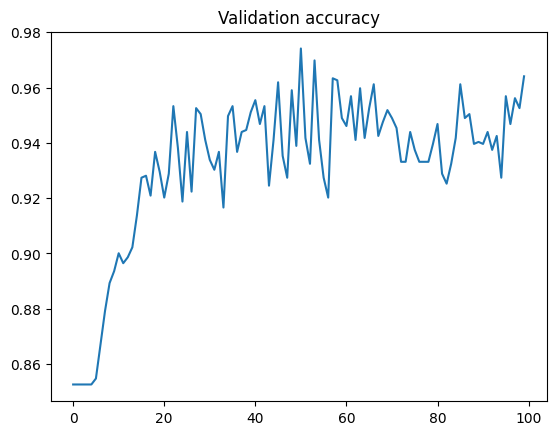

In [29]:
import matplotlib.pyplot as plt

plt.plot(val_accuracy_values)
plt.title('Validation accuracy')

# plt.plot(precision_values)
# plt.title('Precision') 
# plt.savefig('validation_accuracy_65.png', dpi=300, bbox_inches='tight')


In [ ]:
# torch.save(model, 'model.pt')

In [ ]:
# torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#            }, 'checkpoint.pt')